# Byte-Pair Encoding Tokenizer
---
Following Andrej Karpathy's [video](https://www.youtube.com/watch?v=zduSFxRajkE) for tokenizers, building my own BPE tokenizer. From this, will use it as a basis to train my own embedding model based on Word2Vec and analyze the results of that training

## 1) Import Dependencies and Test Data

In [1]:
# Install dependencies
import regex as re
import unittest

# Also defining our regex up here (from GPT-4 tokenizer)
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""

In [2]:
# First, need to import data. We'll use tiny shakespeare -- will be able to clearly see what kinds of words are commonly used in the ye olde times
file_path = '../../data/tinyshakespeare.txt'
with open(file_path, 'r') as file:
    data = file.read()

# Print first 100 chars
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
# Let's also define unittests up here so we can call below
class BPETokenizerTest(unittest.TestCase):

    def setUp(self):
        # Setup your regex and BPETokenizer instance here
        self.regex = GPT4_SPLIT_PATTERN
        self.tokenizer = BPETokenizer(self.regex)
        self.text = data[:100000]


    def test_encode(self):
        # Train the tokenizer with some initial text to set up encoding_map
        self.tokenizer.train(self.text, vocab_size=170)
        encoded = self.tokenizer.encode(self.text)
        # Make sure to assert that encoded is not empty and meets expected structure
        self.assertNotEqual(len(encoded), 0, "Encoding should not be empty.")

    def test_decode(self):
        self.tokenizer.train(self.text, vocab_size=200)
        encoded = self.tokenizer.encode(self.text)
        decoded = self.tokenizer.decode(encoded)
        self.assertEqual(decoded, self.text, "Decoded text should match the original.")

    def test_mergepair_effectiveness(self):
        # This will indirectly test _mergepair via the train method
        text = "test test test test"
        self.tokenizer.train(text, vocab_size=130)
        # After training, the tokenizer should have created a token for the repeated sequence
        # The exact token ID might vary, so we check if the length of encoding_map has increased
        self.assertGreater(len(self.tokenizer.encoding_map), 0, "Encoding map should have merged pairs.")

def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(BPETokenizerTest)
    unittest.TextTestRunner(verbosity=2).run(suite)

## 2) Defining our BPETokenizer Class

### Approach
---
For our tokenizer, we'll create a class called BPETokenizer. Upon instantiation, it will take in a regex expression (optional). Subfunctions include:
1. _encodetext: Takes in raw text and returns 2-D python list of ASCII values (if regex, split by regex; else just 2-D w/ 1 element)
2. _mergepair: helper function to take in your encoded text and a tuple (pair, token) that replaces the pair with the desired token
3. train(text, vocab_size): Function to iteratively convert most frequent byte-pairs to a new token. Saves encoding map to class
4. encode(text): Converts text to tokens; returns as 1-d python list of tokens
5. decode(tokens): Converts tokens to text; returns string.

In [4]:
class BPETokenizer():

    def __init__(self, regex=None):
        self.encoding_map = {}
        self.decoding_map = {}
        self.regex = regex

    def regex_setter(self, re):
        """ Simple setter function for regex """
        self.regex = re

    def encmap_getter(self):
        """ Simple getter to return our encoding map """
        return self.encoding_map
        
    def decmap_getter(self):
        """ Simple getter to return our decoding map """
        return self.decoding_map

    def _encodetext(self, text):
        """
            Takes in raw text and returns 2-D python array of ASCII values (e.g., [[70, 105, 114, 115, 116], [32, 67,...]])
            Replaces non-ASCII with '?'
        """
        if self.regex == None:
            text = [text]
        else:
            text = re.findall(self.regex, text)     # Converts text to ['First', ' Citizen', ':\n', 'Before', ' we', ' proceed',...]
        return list( list(t.encode("ascii", errors="replace")) for t in text )

    def _mergepair(self, tokens, pair_tok):
        """
            Takes in 2-D python list of lists of tokens and iterates through, replacing 'tok' where 'pair' exists
        """
        pair, tok = pair_tok
        merged_tokens = []
        for block in tokens:
            merged_block = []
            skip_next_idx = False
            if (len(block) < 2):
                merged_block = block           # Simply keep our block the same if not 2+ elements
            else:
                for idx in range(len(block)-1):
                    if skip_next_idx:
                        skip_next_idx = False
                        if (idx == len(block)-2):
                            merged_block.append(block[idx+1])
                    elif (block[idx]==pair[0] and block[idx+1]==pair[1]):
                        merged_block.append(tok)
                        skip_next_idx = True
                    elif (idx == len(block)-2):
                        merged_block.extend(block[idx:])
                    else:
                        merged_block.append(block[idx])

            merged_tokens.append(merged_block)
        return merged_tokens

    def train(self, text, vocab_size):
        """
            Takes in raw text and a desired length for max vocabulary size
            Upon completion, sets encoder_map and decoder_map to the BPE mappings (forward, backward resp.) 
        """
        encoded_text = self._encodetext(text)
        encoding_map = {}                 # Create python dictionary of merges
        num_merges = vocab_size - 128     # Number of iterations of BPE
        
        for i in range(num_merges):
            bytepair_count = {}
            for block in encoded_text:
                if len(block) > 1:
                    for idx in range(len(block)-1):
                        pair = (block[idx], block[idx+1])
                        count = bytepair_count.get(pair, 0)
                        bytepair_count[pair] = count+1
            
            # Once done iterating through all the ascii values, sort and assign most freq bytepair to new token
            freq_pair = max(bytepair_count, key=bytepair_count.get)
            new_token = 128 + i
            encoding_map[freq_pair] = new_token
            encoded_text = self._mergepair(encoded_text, (freq_pair, new_token))

        self.encoding_map = encoding_map
        self.decoding_map = {value: key for key, value in encoding_map.items()}

    def encode(self, text):
        """
            Takes in raw text and returns tokenized text (1-D array)
        """
        encodings = list(self.encoding_map.items())
        encoded_text = self._encodetext(text)
        for pair_tok in encodings:
            encoded_text = self._mergepair(encoded_text, pair_tok)
        tokenized_text = [tok for sublist in encoded_text for tok in sublist]
        return tokenized_text

    def decode(self, tokens):
        """
            Takes in tokenized text (1-D array) and returns raw text
        """
        decodings = list(self.decoding_map.items())
        token_text = tokens
        for tok, pair in decodings[::-1]:
            decoded_tokens = []
            for idx, tok_text in enumerate(token_text):
                if tok_text == tok:
                    decoded_tokens.extend( [pair[0], pair[1]] )
                else:
                    decoded_tokens.append(tok_text)
            token_text = decoded_tokens

        decoded_text = ''.join(chr(value) for value in token_text)
        return decoded_text

In [5]:
# Define our data we'll be trianing on and tokenize it
text_data = data[:5000]
tokenizer = BPETokenizer(GPT4_SPLIT_PATTERN)
tokenizer.train(text_data, 200)
tokenized_text = tokenizer.encode(text_data)

In [6]:
# Running our tests 
run_tests()

test_decode (__main__.BPETokenizerTest.test_decode) ... ok
test_encode (__main__.BPETokenizerTest.test_encode) ... ok
test_mergepair_effectiveness (__main__.BPETokenizerTest.test_mergepair_effectiveness) ... ok

----------------------------------------------------------------------
Ran 3 tests in 3.857s

OK


## 3) Analyze our Results

In [7]:
def print_tokens(encoding_map):
    """
    Takes in a dictionary called encoding_map and prints out the text that each token relates to
    """
    encodings = list(encoding_map.items())
    tok_text = {}
    for (tok_1, tok_2), mapped_token in encodings:
        text = []
        # Append the text representation of tok_1
        if tok_1 in tok_text:
            text.append(tok_text[tok_1])
        else:
            text.append(chr(tok_1))
        # Append the text representation of tok_2
        if tok_2 in tok_text:
            text.append(tok_text[tok_2])
        else:
            text.append(chr(tok_2))
        # Join the characters or strings in 'text' list into a single string
        tok_text[mapped_token] = ''.join(text)
    
    tok_text_list = list(tok_text.items())
    for tok, text in tok_text_list:
        # Replace newline characters with a visible representation
        safe_text = text.replace('\n', '\\n')
        print(f"Token: {tok}, Text: '{safe_text}'")

In [8]:
# Let's print out the text associated with our tokens that we encoded
print_tokens(tokenizer.encmap_getter())

Token: 128, Text: ' t'
Token: 129, Text: 'he'
Token: 130, Text: ' a'
Token: 131, Text: 'ou'
Token: 132, Text: 'it'
Token: 133, Text: 'en'
Token: 134, Text: ' w'
Token: 135, Text: 'st'
Token: 136, Text: 're'
Token: 137, Text: ' the'
Token: 138, Text: 'in'
Token: 139, Text: 'll'
Token: 140, Text: ' m'
Token: 141, Text: 'at'
Token: 142, Text: ' s'
Token: 143, Text: ':\n'
Token: 144, Text: '\n\n'
Token: 145, Text: ' c'
Token: 146, Text: 'on'
Token: 147, Text: ' y'
Token: 148, Text: ' b'
Token: 149, Text: 'or'
Token: 150, Text: ' you'
Token: 151, Text: 'er'
Token: 152, Text: 'ir'
Token: 153, Text: 'is'
Token: 154, Text: ' C'
Token: 155, Text: 'iti'
Token: 156, Text: ' p'
Token: 157, Text: ' f'
Token: 158, Text: 'us'
Token: 159, Text: 'itiz'
Token: 160, Text: 'itizen'
Token: 161, Text: ' h'
Token: 162, Text: ' Citizen'
Token: 163, Text: 'ed'
Token: 164, Text: '.\n\n'
Token: 165, Text: ' to'
Token: 166, Text: 'nd'
Token: 167, Text: 'ar'
Token: 168, Text: 'es'
Token: 169, Text: ' he'
Token: 17

In [9]:
# We can check the compression rate
print(f"Length of original string:     {len(text_data)}")
print(f"Length of tokenized string:    {len(tokenized_text)}")
print(f"Compression (% of original):   {((len(tokenized_text) / len(text_data))*100):.2f}%")
print("\n")

# Let's make sure the text is properly decodable as well
print(tokenizer.decode(tokenized_text[:200]))

Length of original string:     5000
Length of tokenized string:    3010
Compression (% of original):   60.20%


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a v


## 4) Analyzing Runtime Performance
---
We'll try to optimize our code to see how much we can improve the runtime!

### Define Dependencies and Helper Functions

In [30]:
# Import libraries to analyze runtime performance 
import cProfile
import pstats
import io
import time as pytime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.patches import Patch

In [24]:
def plot_time_vs_vocab_size(data_size):
    times = [train_run_times[(data_size, v)] for v in vocab_sizes]
    
    plt.figure(figsize=(10, 6))
    plt.plot(vocab_sizes, times, marker='o')
    plt.title(f"Training Time vs. Vocabulary Size for Data Size = {data_size}")
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Time (seconds)")
    plt.grid(True)
    plt.show()

def plot_time_vs_data_size():
    plt.figure(figsize=(5, 3))
    
    for v in vocab_sizes:
        times = [train_run_times[(d, v)] for d in data_sizes]
        plt.plot(data_sizes, times, marker='o', label=f"Vocab Size {v}")
    
    plt.title("Training Time vs. Data Size")
    plt.xlabel("Data Size")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_time_vs_encoding_length():
    plt.figure(figsize=(5, 3))
    
    for v in vocab_sizes:
        times = [encoding_run_times[(v, l)] for l in encoding_lengths]
        plt.plot(encoding_lengths, times, marker='o', label=f"Vocab Size {v}")
    
    plt.title("Encoding Time vs. Encoding Length")
    plt.xlabel("Encoding Length")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def train_polynomial_model_from_dict(data_dict, degree=2):
    """
    Trains a polynomial regression model from a dictionary where keys are tuples representing features
    and values are targets.
    
    Parameters:
        data_dict (dict): A dictionary with keys as tuples representing feature values and values as target values.
        degree (int): The degree of the polynomial features.
        
    Returns:
        (X, y): Tuple of our data used in our training
        poly_model (LinearRegression): The trained polynomial regression model.
        poly (PolynomialFeatures): The polynomial feature transformer used for the model.
    """
    # Extract features (X) and targets (y) from the dictionary
    X = np.array(list(data_dict.keys()))
    y = np.array(list(data_dict.values()))

    # Transform your features into polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Fit the linear regression model on polynomial features
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    
    return (X, y), poly_model, poly

In [31]:
def plot_polynomial_regression_surface(X, y, poly, poly_model, feature_labels=['Feature 1', 'Feature 2'], target_label='Target'):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of original data points
    scatter = ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Actual Data')

    # Generate mesh for the surface
    x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
    x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
    x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
    mesh_flat = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    mesh_poly = poly.transform(mesh_flat)  # Transform to polynomial features
    y_mesh = poly_model.predict(mesh_poly)  # Predict using the polynomial model
    y_mesh = y_mesh.reshape(x1_mesh.shape)

    # Plot the surface
    surface = ax.plot_surface(x1_mesh, x2_mesh, y_mesh, color='orange', alpha=0.5, edgecolor='none')

    ax.set_xlabel(feature_labels[0])
    ax.set_ylabel(feature_labels[1])
    ax.set_zlabel(target_label)
    ax.set_title(f'3D Plot of {feature_labels[0]}, {feature_labels[1]} vs. {target_label} with Polynomial Regression Surface')

    # Manually define legend
    scatter_legend = Patch(color='blue', label='Actual Data')
    surface_legend = Patch(color='orange', label='Polynomial Regression Model')
    plt.legend(handles=[scatter_legend, surface_legend])

    plt.show()


### Analyzing Time for Various Training Runs
---
*Takeaway*: Looking at the chart of our run-time, we're getting fairly linear scaling w.r.t. both increases in vocabulary size and dictionary length. However, at larger scales this starts to grow parabolically. We can train a polynomial regression on this data and use it to estimate our run-time on larger datasets.

We see that if we use our entire dataset length and try to train for a vocab size of 2048, it will take approximately: **4min 47sec**

In [12]:
# Let's compute the time required to run based on size of dataset and size of vocabulary and see how they grow
data_sizes      = [10000, 30000, 100000, 300000]
vocab_sizes     = [200, 300, 500, 1000]

train_run_times = {}

for d in data_sizes:
    runtime_testdata = data[:d]
    for v in vocab_sizes:
        rt_tokenizer = BPETokenizer(GPT4_SPLIT_PATTERN)
        
        start_time = pytime.time()  # Start timer
        rt_tokenizer.train(runtime_testdata, v)
        end_time = pytime.time()  # End timer
        
        run_time = end_time - start_time
        train_run_times[(d, v)] = run_time  # Save the time with (d, v) as the key
        print(f"D: {d}, V: {v}; Time: {run_time:.2f}s")

D: 10000, V: 200; Time: 0.15s
D: 10000, V: 300; Time: 0.31s
D: 10000, V: 500; Time: 0.58s
D: 10000, V: 1000; Time: 0.88s
D: 30000, V: 200; Time: 0.54s
D: 30000, V: 300; Time: 1.07s
D: 30000, V: 500; Time: 1.83s
D: 30000, V: 1000; Time: 3.45s
D: 100000, V: 200; Time: 1.86s
D: 100000, V: 300; Time: 3.88s
D: 100000, V: 500; Time: 6.91s
D: 100000, V: 1000; Time: 12.37s
D: 300000, V: 200; Time: 5.82s
D: 300000, V: 300; Time: 11.76s
D: 300000, V: 500; Time: 22.07s
D: 300000, V: 1000; Time: 38.05s


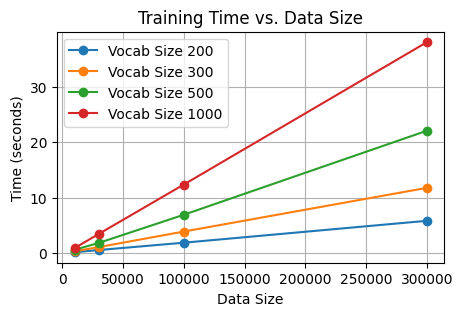

In [27]:
# plot_time_vs_vocab_size(data_sizes[4])
plot_time_vs_data_size()

Predicted Time: 287.44 seconds


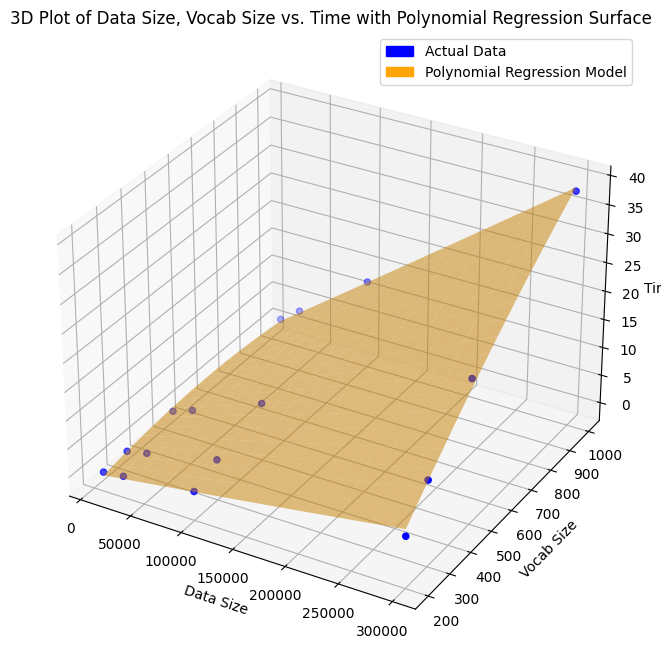

In [32]:
# Train our polynomial fit
train_data, train_polymodel, train_poly = train_polynomial_model_from_dict(train_run_times, degree=2)

# Print our estimates
data_point = np.array([[len(data), 2048]])  # (Data_size, vocab_size)
data_point_poly = train_poly.transform(data_point)
predicted_time_poly = train_polymodel.predict(data_point_poly)
print(f"Predicted Time: {predicted_time_poly[0]:.2f} seconds")

# Visualize our graph
plot_polynomial_regression_surface(train_data[0], train_data[1], train_poly, train_polymodel, feature_labels=['Data Size', 'Vocab Size'], target_label='Time')

### Analyzing Runtime of Encoding
---
We can see that the runtime of encoding grows with slight parabolic trajectory. If we train a polynomial regression on this and try to encode 1M tokens with a vocab_size of 2048, it will take **4 minutes 36 seconds** which is quite long. We can get this down.

In [34]:
# Let's compute the time required to run based on size of dataset and size of vocabulary and see how they grow
encoding_traindata = data[:10000]
vocab_sizes_enc = [200, 300, 500, 1000]
encoding_lengths = [10000, 30000, 100000, 300000]

encoding_run_times = {}

for v in vocab_sizes_enc:
    rt_tokenizer = BPETokenizer(GPT4_SPLIT_PATTERN)
    rt_tokenizer.train(encoding_traindata, v)
    
    for l in encoding_lengths:
        start_time = pytime.time()  # Start timer
        rt_tokenizer.encode(data[:l])
        end_time = pytime.time()  # End timer
        run_time = end_time - start_time
        encoding_run_times[(v, l)] = run_time  # Save the time with (l, v) as the key
        print(f"V: {v}, L: {l}; Time: {run_time:.2f}s")

V: 200, L: 10000; Time: 0.06s
V: 200, L: 30000; Time: 0.43s
V: 200, L: 100000; Time: 1.46s
V: 200, L: 300000; Time: 4.67s
V: 300, L: 10000; Time: 0.18s
V: 300, L: 30000; Time: 0.88s
V: 300, L: 100000; Time: 3.31s
V: 300, L: 300000; Time: 10.54s
V: 500, L: 10000; Time: 0.28s
V: 500, L: 30000; Time: 1.51s
V: 500, L: 100000; Time: 6.03s
V: 500, L: 300000; Time: 18.89s
V: 1000, L: 10000; Time: 0.50s
V: 1000, L: 30000; Time: 2.58s
V: 1000, L: 100000; Time: 11.89s
V: 1000, L: 300000; Time: 38.54s


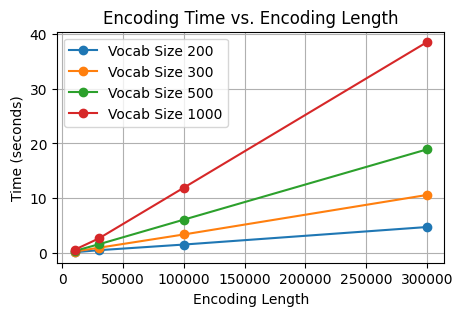

In [35]:
plot_time_vs_encoding_length()

Predicted Time: 276.43 seconds


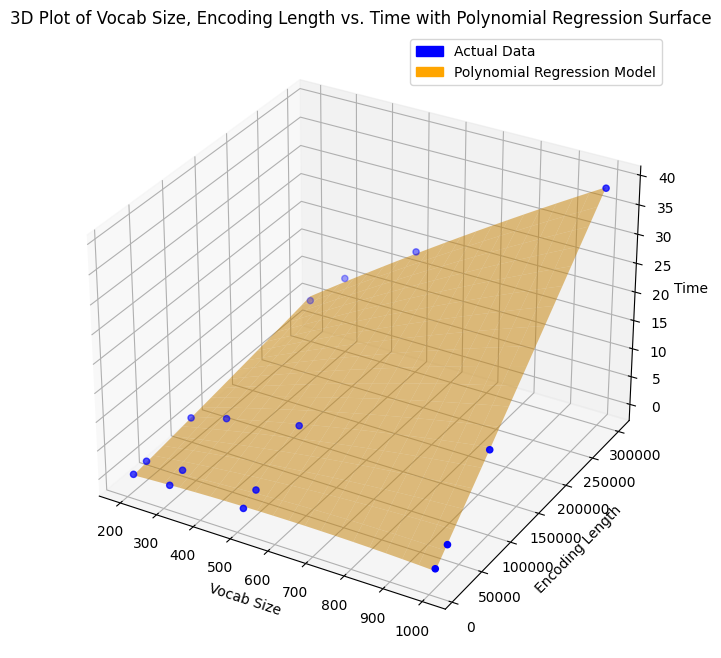

In [36]:
# Train our polynomial fit
enc_data, enc_polymodel, enc_poly = train_polynomial_model_from_dict(encoding_run_times, degree=2)

# Print our estimates
data_point = np.array([[2048, 1000000]])  # (Vocab_size, Encoding_length)
data_point_poly = enc_poly.transform(data_point)
predicted_time_poly = enc_polymodel.predict(data_point_poly)
print(f"Predicted Time: {predicted_time_poly[0]:.2f} seconds")

# Visualize our graph
plot_polynomial_regression_surface(enc_data[0], enc_data[1], enc_poly, enc_polymodel, feature_labels=['Vocab Size', 'Encoding Length'], target_label='Time')

### Other Runtime Analysis Options

In [ ]:
# Define our code that we want to test runtime on
runtime_testdata = data[:100000]
rt_tokenizer = BPETokenizer(GPT4_SPLIT_PATTERN)

def profile_your_function():
    rt_tokenizer.train(runtime_testdata, 500)
    # rt_tokenized_text = rt_tokenizer.encode(runtime_testdata)
    

In [ ]:
# Create a Profile object
pr = cProfile.Profile()
pr.enable()  # Start collecting profiling data

# Call the function or part of the code you want to profile
profile_your_function()

pr.disable()  # Stop collecting profiling data

# Use io.StringIO to capture the profiling output
s = io.StringIO()
# Sort the statistics by cumulative time spent and print the top parts
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats()

# Print the profiling result
print(s.getvalue())